In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### <b>[코드 구현] Show and Tell: A Neural Image Caption Generator (CVPR 2015)</b>
* 본 소스코드는 원본 논문에서 제안한 아키텍처를 최대한 따르고 있습니다.
* CNN 아키텍처로 ResNet-101을 사용합니다.
* 학습용 데이터셋: <b>Flickr8k</b>
* 참고한 소스코드: [yunjey](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)

#### <b>Flickr8k 데이터셋 다운로드</b>

* Flickr8k 데이터셋 다운로드 및 압축 해제

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXVy7_7pF5FIsPp6WfXXfWgBNfUKx8N1VrTisN8FbGYG9w?download=1 -O Flickr8k_dataset.zip

--2022-06-28 04:02:02--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXVy7_7pF5FIsPp6WfXXfWgBNfUKx8N1VrTisN8FbGYG9w?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/Flickr8k_dataset.zip?ga=1 [following]
--2022-06-28 04:02:04--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/Flickr8k_dataset.zip?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1112971163 (1.0G) [application/x-zip-compressed]
Saving to: ‘Flickr8k_dataset.zip’

Flickr8k_dataset.zi 100%[===================>]   1.04G  31.2MB/s    in 43s     

2022-06-28 04:02:47 (24.6 MB/s) - 

In [ ]:
%%capture
!unzip Flickr8k_dataset.zip -d ./Flickr8k_dataset

#### <b>필요한 버전의 라이브러리 설치</b>

* BLEU Score 계산을 위해 라이브러리 재설치

In [ ]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 3.2 MB/s 
     |████████████████████████████████| 1.2 MB 65.9 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0


#### <b>이미지 크기 조정(Resize)</b>

* 데이터셋에 포함된 모든 이미지의 크기를 조정합니다.

In [ ]:
import os
from PIL import Image

image_dir = "./Flickr8k_dataset/Images" # 원본 이미지 파일 경로
train_image_dir = "./resized_train/images" # 크기가 조정된 이미지가 담길 경로 (학습)
val_image_dir = "./resized_val/images" # 크기가 조정된 이미지가 담길 경로 (평가)
test_image_dir = "./resized_test/images" # 크기가 조정된 이미지가 담길 경로 (테스트)
size = [256, 256] # 조정될 이미지 크기


def resize_image(image, size):
    # 이미지를 특정 크기로 조정
    return image.resize(size, Image.ANTIALIAS)

# image_dir 내부에 있는 모든 이미지의 크기를 바꾸어 결과 폴더로 옮기기
if not os.path.exists(train_image_dir):
    os.makedirs(train_image_dir)
if not os.path.exists(val_image_dir):
    os.makedirs(val_image_dir)
if not os.path.exists(test_image_dir):
    os.makedirs(test_image_dir)

images = sorted(os.listdir(image_dir)) # 이미지와 캡션 모두 파일 이름별로 정렬해서 매칭
num_images = len(images)
num_train_images = 6000 # 6000개는 학습용 데이터로 이용
num_val_images = 1000 # 1000개는 평가용 데이터로 이용

for i, image in enumerate(images):
    if (i + 1) <= num_train_images:
        output_dir = train_image_dir
    elif (i + 1) <= num_train_images + num_val_images:
        output_dir = val_image_dir
    else:
        output_dir = test_image_dir
    with open(os.path.join(image_dir, image), 'rb+') as f:
        with Image.open(f) as img:
            img = resize_image(img, size)
            img.save(os.path.join(output_dir, image), img.format)
    if (i + 1) % 500 == 0:
        print(f"[{i + 1}/{num_images}] Resized the images and saved into '{output_dir}'")

[500/8091] Resized the images and saved into './resized_train/images'
[1000/8091] Resized the images and saved into './resized_train/images'
[1500/8091] Resized the images and saved into './resized_train/images'
[2000/8091] Resized the images and saved into './resized_train/images'
[2500/8091] Resized the images and saved into './resized_train/images'
[3000/8091] Resized the images and saved into './resized_train/images'
[3500/8091] Resized the images and saved into './resized_train/images'
[4000/8091] Resized the images and saved into './resized_train/images'
[4500/8091] Resized the images and saved into './resized_train/images'
[5000/8091] Resized the images and saved into './resized_train/images'
[5500/8091] Resized the images and saved into './resized_train/images'
[6000/8091] Resized the images and saved into './resized_train/images'
[6500/8091] Resized the images and saved into './resized_val/images'
[7000/8091] Resized the images and saved into './resized_val/images'
[7500/8091]

#### <b>캡션을 이용해 Vocabulary 만들기</b>

* 현재의 Flickr8k_dataset에 <b>총 8,091개의 이미지</b>가 포함되어 있습니다.
* 이미지마다 5개의 캡션이 붙어 있으므로 <b>총 40,455개의 문장</b>이 존재합니다.

In [ ]:
import pickle
import nltk
from collections import Counter

nltk.download('punkt')

caption_path = "./Flickr8k_dataset/captions.txt" # 원본 캡션(caption) 파일
vocab_path = "./vocab.pkl" # 단어 사전 결과 파일
word_threshold = 4 # 최소 단어 등장 횟수
train_caption_path = "./resized_train/captions.txt" # 크기가 조정된 이미지의 캡션(caption)이 담길 경로 (학습)
val_caption_path = "./resized_val/captions.txt" # 크기가 조정된 이미지의 캡션(caption)이 담길 경로 (평가)
test_caption_path = "./resized_test/captions.txt" # 크기가 조정된 이미지의 캡션(caption)이 담길 경로 (테스트)


class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}   # 단어의 위치를 index 형태로 바꿔줌(나중에 임베딩 하기 위함)
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']    # 존재하지 않는 단어를 unknown 토큰으로 넘겨줌
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

counter = Counter()

with open(caption_path, "r") as f:
    lines = sorted(f.readlines()[1:])
    for i in range(len(lines)):
        line = lines[i]
        if (i + 1) <= num_train_images * 5: # 이미지당 캡션이 5개씩 존재
            output_caption = train_caption_path
        elif (i + 1) <= (num_train_images + num_val_images) * 5:
            output_caption = val_caption_path
        else:
            output_caption = test_caption_path
        index = line.find(",") # 캡션(caption) 문자열의 시작점 찾기
        caption = line[index + 1:] # 캡션(caption) 문자열 기록
        tokens = nltk.tokenize.word_tokenize(caption.lower()) # 문자열 토큰화
        counter.update(tokens) # 각 토큰의 개수 세기
        with open(output_caption, "a") as output_caption_f:
            output_caption_f.write(line)

# 단어의 빈도수가 특정 임계치(threshold) 이상인 경우에만 사용
words = [word for word, cnt in counter.items() if cnt >= word_threshold]

# Vocabulary 객체 생성
vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>') # unknown 토큰

# Vocabulary 객체에 모든 단어를 담기
for word in words:
    vocab.add_word(word)

# Vocabulary 파일 저장
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# 학습(train) 데이터셋의 캡션 수
!wc -l ./resized_train/captions.txt
# 평가(val) 데이터셋의 캡션 수
!wc -l ./resized_val/captions.txt
# 테스트(test) 데이터셋의 캡션 수
!wc -l ./resized_test/captions.txt

30000 ./resized_train/captions.txt
5000 ./resized_val/captions.txt
5455 ./resized_test/captions.txt


#### <b>커스텀 데이터셋 클래스 정의</b>

* Flickr8kDataset 클래스를 정의합니다.

In [ ]:
import torch.utils.data as data


# Flickr8k 데이터셋 클래스 정의
class Flickr8kDataset(data.Dataset):
    def __init__(self, root, captions, vocab, transform=None):
        self.root = root # 이미지가 존재하는 경로
        with open(captions, "r") as f:
             lines = f.readlines()
             self.captions = [] # 캡션(caption) 정보를 담을 리스트
             for line in lines: # 첫 번째 줄부터 바로 캡션 정보 존재
                index = line.find(",") # 캡션(caption) 문자열의 시작점 찾기
                path = line[:index] # 이미지 파일 이름
                caption = line[index + 1:] # 캡션(caption) 문자열 기록
                self.captions.append((path, caption))
        self.vocab = vocab
        self.transform = transform

    # 이미지와 캡션(caption)을 하나씩 꺼내는 메서드
    def __getitem__(self, index):
        vocab = self.vocab
        path = self.captions[index][0]
        caption = self.captions[index][1]

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # 캡션(caption) 문자열을 토큰 형태로 바꾸기
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])  # 단어만이 start와 end 토큰 안에 들어갈 수 있게 설정
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.captions)

In [ ]:
# 이미지와 캡션(caption)으로 구성된 튜플을 배치(batch)로 만들기
def collate_fn(data):
    """
    [입력]
    * data: list of tuple (image, caption). 
        * image: torch tensor of shape (3, 256, 256).
        * caption: torch tensor of shape (?); variable length.
    [출력]
    * images: torch tensor of shape (batch_size, 3, 256, 256). 
    * targets: torch tensor of shape (batch_size, padded_length).
    * lengths: list; valid length for each padded caption.
    """
    # Caption 길이로 각 데이터를 내림차순 정렬
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # 리스트 형태의 이미지들을 텐서 하나로 합치기(데이터 개수, 3, 256, 256)
    images = torch.stack(images, 0)

    # 리스트 형태의 캡션들을 텐서 하나로 합치기(데이터 개수, 문장 내 최대 토큰 개수)
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # 하나씩 캡션을 확인하며 앞 부분의 내용을 패딩이 아닌 원래 토큰으로 채우기
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def collate_fn_test(data):
    # 기존 순서를 그대로 사용 (차례대로 5개씩 같은 이미지를 표현)
    images, captions = zip(*data)

    # 리스트 형태의 이미지들을 텐서 하나로 합치기(데이터 개수, 3, 256, 256)
    images = torch.stack(images, 0)

    # 리스트 형태의 캡션들을 텐서 하나로 합치기(데이터 개수, 문장 내 최대 토큰 개수)
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # 하나씩 캡션을 확인하며 앞 부분의 내용을 패딩이 아닌 원래 토큰으로 채우기
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

# 커스텀 Flickr8k 데이터셋을 위한 DataLoader 객체 반환. 이 get_loader는 배치 사이즈만큼 데이터를 받기 위해 사용
def get_loader(root, captions, vocab, transform, batch_size, shuffle, num_workers, testing):
    flickr8k = Flickr8kDataset(root=root, captions=captions, vocab=vocab, transform=transform)
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    if not testing:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)
    else:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn_test)
    return data_loader

#### <b>모델 정의</b>

* 학습을 위한 Encoder 및 Decoder 모델을 정의합니다.
* 본 실습에서는 <b>사전 학습된(pre-trained) ResNet-101 모델</b>을 CNN으로 사용합니다.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        # 사전 학습된(pre-trained) ResNet-101을 불러와 FC 레이어를 교체
        super(EncoderCNN, self).__init__()
        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-1] # 마지막 FC 레이어를 제거
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size) # 결과(output) 차원을 임베딩 차원으로 변경(우리가 원하는 사이즈를 인풋으로 받기 위함)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        # 입력 이미지에서 특징 벡터(feature vectors)
        with torch.no_grad(): # 네트워크의 앞 부분은 변경되지 않도록 하기
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):  # 이게 굳이 rnn일 필요 없음. 순서가 중요하지 않기 때문
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        # 하이퍼 파라미터(hyper-parameters) 설정 및 레이어 생성
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        # 이미지 특징 벡터(feature vectors)로부터 캡션(caption) 생성
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1) # 이미지 특징과 임베딩 연결
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) # 패딩을 넣어 차원 맞추기(긴 문장에 차원을 맞춰줌)
        hiddens, _ = self.lstm(packed) # 다음 hidden state 구하기
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        # 간단히 그리디(greedy) 탐색으로 캡션(caption) 생성하기
        sampled_indexes = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)
            sampled_indexes.append(predicted)
            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)
        sampled_indexes = torch.stack(sampled_indexes, 1) # sampled_indexes: (batch_size, max_seq_length)
        return sampled_indexes

#### <b>학습 및 평가 준비하기</b>

* 학습 및 평가를 준비합니다.

In [ ]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = "models/" # 학습된 모델이 저장될 경로
crop_size = 224 # 랜덤하게 잘라낼 이미지 크기
vocab_path = "./vocab.pkl" # 전처리된 Vocabulary 파일 경로

# 모델 디렉토리 만들기
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Vocabulary 파일 불러오기
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# 사전 학습된(pre-trained) ResNet에 적용된 전처리 및 정규화 파라미터를 그대로 사용합니다.
train_transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),   # 데이터 augmentation을 train 이미지에 대해서만 수행
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
num_workers = 2

# 데이터 로더(data loader) 선언
train_data_loader = get_loader(train_image_dir, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False) 
val_data_loader = get_loader(val_image_dir, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False)
test_data_loader = get_loader(test_image_dir, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True)

In [ ]:
# 모델 하이퍼 파라미터 설정
embed_size = 256 # 임베딩(embedding) 차원
hidden_size = 512 # LSTM hidden states 차원
num_layers = 1 # LSTM의 레이어 개수

# 모델 객체 선언
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

num_epochs = 5
learning_rate = 0.001

log_step = 20 # 로그를 출력할 스텝(step)
save_step = 1000 # 학습된 모델을 저장할 스텝(step)

# 손실(loss) 및 최적화 함수 선언
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

#### <b>학습 진행</b>

* 전체 학습 과정에서 <b>약 15분~30분</b>이 소요됩니다.

In [ ]:
import time
import numpy as np

start_time = time.time() # 전체 학습 시간 측정

# 모델 학습 진행
for epoch in range(num_epochs):

    # 먼저 학습 진행하기
    print("[ Training ]")
    total_loss = 0
    total_count = 0
    total_step = len(train_data_loader)
    for i, (images, captions, lengths) in enumerate(train_data_loader):
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # 순전파(forward), 역전파(backward) 및 학습 진행
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # 손실(loss) 값 계산
        total_loss += loss.item()
        total_count += images.shape[0]

        # 로그(log) 정보 출력
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
                  .format(epoch, num_epochs, i, total_step, total_loss / total_count, np.exp(loss.item()), time.time() - start_time))

    # 모델 파일 저장하기
    torch.save(decoder.state_dict(), os.path.join(model_path, f'decoder-{epoch + 1}.ckpt'))
    torch.save(encoder.state_dict(), os.path.join(model_path, f'encoder-{epoch + 1}.ckpt'))
    print(f"Model saved: {os.path.join(model_path, f'decoder-{epoch + 1}.ckpt')}")
    print(f"Model saved: {os.path.join(model_path, f'encoder-{epoch + 1}.ckpt')}")

    # 학습 이후에 평가 진행하기
    print("[ Validation ]")
    total_loss = 0
    total_count = 0
    total_step = len(val_data_loader)
    with torch.no_grad():
        for i, (images, captions, lengths) in enumerate(val_data_loader):
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # 순전파(forward) 진행
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
  
            # 손실(loss) 값 계산
            total_loss += loss.item()
            total_count += images.shape[0]

            # 로그(log) 정보 출력
            if i % log_step == 0:
                print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
                      .format(epoch, num_epochs, i, total_step, total_loss / total_count, np.exp(loss.item()), time.time() - start_time))

[ Training ]
Epoch [0/5], Step [0/235], Average Loss: 0.0636, Perplexity: 3441.4072, Elapsed time: 1.8998s
Epoch [0/5], Step [20/235], Average Loss: 0.0474, Perplexity: 118.4441, Elapsed time: 14.9230s
Epoch [0/5], Step [40/235], Average Loss: 0.0413, Perplexity: 65.5676, Elapsed time: 27.8867s
Epoch [0/5], Step [60/235], Average Loss: 0.0379, Perplexity: 43.8960, Elapsed time: 41.0072s
Epoch [0/5], Step [80/235], Average Loss: 0.0356, Perplexity: 37.4947, Elapsed time: 54.2857s
Epoch [0/5], Step [100/235], Average Loss: 0.0340, Perplexity: 33.3924, Elapsed time: 68.0889s
Epoch [0/5], Step [120/235], Average Loss: 0.0327, Perplexity: 32.6470, Elapsed time: 81.9538s
Epoch [0/5], Step [140/235], Average Loss: 0.0317, Perplexity: 23.5663, Elapsed time: 96.1828s
Epoch [0/5], Step [160/235], Average Loss: 0.0309, Perplexity: 25.4942, Elapsed time: 110.5870s
Epoch [0/5], Step [180/235], Average Loss: 0.0302, Perplexity: 24.9817, Elapsed time: 125.2563s
Epoch [0/5], Step [200/235], Average Lo

In [ ]:
# 학습된 모델 저장
from google.colab import files

files.download('models/encoder-5.ckpt')
files.download('models/decoder-5.ckpt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### <b>결과 확인</b>

* 평가 데이터셋 중 하나의 이미지를 골라 학습된 모델을 이용하여 결과를 확인합니다.

In [ ]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

image_path = "/content/drive/MyDrive/5조/290293419_801774697474743_7220590883496608579_n.jpg" # 캡션(caption)을 생성할 입력 이미지
encoder_path = "./nic_encoder_ResNet101.ckpt" # path for trained encoder
decoder_path = "./nic_decoder_ResNet101.ckpt" # path for trained decoder
vocab_path = "./vocab.pkl" # path for vocabulary wrapper

# Model parameters (should be same as paramters in train.py)
embed_size = 256 # dimension of word embedding vectors
hidden_size = 512 # dimension of lstm hidden states
num_layers = 1 # number of layers in lstm

In [ ]:
# 이미지 전처리(image preprocessing)
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build models
encoder = EncoderCNN(embed_size).eval() # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# Prepare an image
image = load_image(image_path, transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy() # (1, max_seq_length) -> (max_seq_length)

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids: # 하나씩 단어 인덱스를 확인하며
    word = vocab.idx2word[word_id] # 단어 문자열로 바꾸어 삽입
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

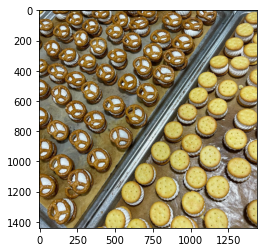

<start> a child is sitting on a wooden bench . <end>


In [ ]:
import matplotlib.pyplot as plt

# 이미지 및 생성된 캡션(caption) 문장 출력
image = Image.open(image_path)
plt.imshow(np.asarray(image))
plt.show()
print(sentence)

#### <b>BLEU Score</b> 계산

* 테스트(test) 데이터셋을 이용하여 BLEU 점수(score)를 계산합니다.
* 문장 제너레이팅이 아니므로 blue score 계산은 필요가 없을듯

In [ ]:
predictions = []
answers = []
answers_per_image = []

total_step = len(test_data_loader)
cnt = 0

with torch.no_grad():
    for i, (images, captions, lengths) in enumerate(test_data_loader):
        images = images.to(device)
        captions = captions.to(device)

        # 순전파(forward) 진행
        features = encoder(images)
        sampled_ids_list = decoder.sample(features)

        for index in range(len(images)):
            sampled_ids = sampled_ids_list[index].cpu().numpy()

            # 정답 문장(answer sentences)
            answer = []
            for word_id in captions[index]: # 하나씩 단어 인덱스를 확인하며
                word = vocab.idx2word[word_id.item()] # 단어 문자열로 바꾸어 삽입
                answer.append(word)
                if word == '<end>':
                    break
            answers_per_image.append(answer[1:-1]) # 정답 문장을 삽입 (<sos>과 <eos>는 제외)

            if (cnt + 1) % 5 == 0: # 이미지당 캡션이 5개씩 존재
                answers.append(answers_per_image) # 5개를 한꺼번에 리스트로 삽입
                answers_per_image = []

                # 예측한 문장(predicted sentences)
                prediction = []
                for word_id in sampled_ids: # 하나씩 단어 인덱스를 확인하며
                    word = vocab.idx2word[word_id] # 단어 문자열로 바꾸어 삽입
                    prediction.append(word)
                    if word == '<end>':
                        break
                predictions.append(prediction[1:-1]) # 예측한 문장에 대해서는 1개만 삽입 (<sos>과 <eos>는 제외)
            cnt += 1

        if i % log_step == 0:
            print(f"[ Testing ] Batch size: {i}/{total_step}")

[ Testing ] Batch size: 0/43
[ Testing ] Batch size: 20/43
[ Testing ] Batch size: 40/43


In [ ]:
print("예측한 문장의 수:", len(predictions))
print("정답 문장 집합의 수 (5개씩):", len(answers))

예측한 문장의 수: 1091
정답 문장 집합의 수 (5개씩): 1091


In [ ]:
index = 2
print("[ 정답 캡션들 ]")
for answer in answers[index]:
    print(answer)

print("[ 예측된 캡션 ]")
print(predictions[index])

[ 정답 캡션들 ]
['a', 'brown', 'and', 'white', 'dog', 'is', 'playing', 'with', 'a', 'toy', 'in', 'a', 'field', 'of', 'green', 'grass', 'and', 'clover', '.']
['a', 'brown', 'and', 'white', 'dog', 'retrieving', 'a', 'white', 'plushie', 'toy', 'in', 'a', 'field', 'of', 'clover', '.']
['a', 'distorted', 'photo', 'of', 'a', 'playing', 'dog', 'in', 'a', 'flower', 'field']
['a', 'dog', 'in', 'grass', 'carrying', 'a', 'toy', 'in', 'its', 'mouth', '.']
['the', 'little', 'brown', 'dog', 'is', 'running', 'through', 'a', 'clover', 'field', 'with', 'a', 'white', 'object', 'in', 'its', 'mouth', '.']
[ 예측된 캡션 ]
['a', 'dog', 'runs', 'through', 'the', 'grass', '.']


In [ ]:
from torchtext.data.metrics import bleu_score

bleu = bleu_score(predictions, answers, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
print(f'Total BLEU Score = {bleu * 100:.2f}')

individual_bleu1_score = bleu_score(predictions, answers, max_n=4, weights=[1, 0, 0, 0])
individual_bleu2_score = bleu_score(predictions, answers, max_n=4, weights=[0, 1, 0, 0])
individual_bleu3_score = bleu_score(predictions, answers, max_n=4, weights=[0, 0, 1, 0])
individual_bleu4_score = bleu_score(predictions, answers, max_n=4, weights=[0, 0, 0, 1])

print(f'Individual BLEU1 score = {individual_bleu1_score * 100:.2f}') 
print(f'Individual BLEU2 score = {individual_bleu2_score * 100:.2f}') 
print(f'Individual BLEU3 score = {individual_bleu3_score * 100:.2f}') 
print(f'Individual BLEU4 score = {individual_bleu4_score * 100:.2f}') 

cumulative_bleu1_score = bleu_score(predictions, answers, max_n=4, weights=[1, 0, 0, 0])
cumulative_bleu2_score = bleu_score(predictions, answers, max_n=4, weights=[1/2, 1/2, 0, 0])
cumulative_bleu3_score = bleu_score(predictions, answers, max_n=4, weights=[1/3, 1/3, 1/3, 0])
cumulative_bleu4_score = bleu_score(predictions, answers, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

print(f'Cumulative BLEU1 score = {cumulative_bleu1_score * 100:.2f}') 
print(f'Cumulative BLEU2 score = {cumulative_bleu2_score * 100:.2f}') 
print(f'Cumulative BLEU3 score = {cumulative_bleu3_score * 100:.2f}') 
print(f'Cumulative BLEU4 score = {cumulative_bleu4_score * 100:.2f}') 

KeyboardInterrupt: ignored